In [2]:
from torch.optim import Adam, SGD
import numpy as np, torch.nn as nn, pandas as pd,\
torch.nn.functional as F, matplotlib.pyplot as plt,\
seaborn as sn
import torch, logging, os, re, random, pickle, logging
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score, 
    precision_recall_fscore_support
)
import argparse
import itertools
from copy import deepcopy
from torch.optim.lr_scheduler import StepLR
from src.pipeline import pipeline
from src.training_utils import training_utils
from torchvision.utils import save_image
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from torch.utils import data as tdataset
import torch.nn as nn
import torch.nn.functional as F
import torch
import argparse
import os

EXP_HPARAMS = {
    "params": (
        {},
    ),
    "seeds": (3957,),
}

# Read the comment right before cal_linearAcc

In [ ]:
class TrainTest():
    def __init__(self, model, optimizer, scheduler, criterion):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        
    def train(
        self, train_loader,
        num_epochs, device, eval_interval,
        clip=None, model_path=None, save_per_epoch=None,
        results_path=None, defaults=None, **kwargs
    ):
        total_itrs = num_epochs*len(train_loader)
        itr = 0
        self.model.train()
        for epoch in range(num_epochs):
            for i, (real_imgs, labels) in enumerate(train_loader):
                real_imgs, labels = real_imgs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                output = self.model(real_imgs)
                tr_loss = self.criterion(output, labels.view(-1))
                # nn.utils.clip_grad_norm_(model.parameters(), clip)
                print(f'Training: {itr}/{total_itrs} -- loss: {tr_loss.item()}')
                tr_loss.backward()
                self.optimizer.step()
                itr += 1
            self.scheduler.step()

    def save_results(self, results_path, name, results):
        results_dir = '/'.join(results_path.split('/')[:-1])
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
        with open(os.path.join(results_dir, f'results_{name}.pkl'), 'wb') as save_file:
            pickle.dump(results, save_file)

    def test(self, test_loader, device, all_labels, results_path=None, defaults=None):
        true_labels, pred_labels = [], []
        self.model.eval()
        with torch.no_grad():
            for i, (real_imgs, labels) in enumerate(test_loader):
                real_imgs, labels = real_imgs.to(device), labels.to(device)
                test_output = self.model(real_imgs)
                _, temp_pred = test_output.max(dim=1)
                true_labels.append(labels.view(-1))
                pred_labels.append(temp_pred)
        pred_labels = torch.cat(pred_labels).cpu()
        true_labels = torch.cat(true_labels).cpu()
        test_accuracy = torch.sum(pred_labels == true_labels).item() / true_labels.size()[0]
        prf = precision_recall_fscore_support(
            true_labels,
            pred_labels,
            labels=all_labels,
            average='weighted'
        )
        confm = confusion_matrix(true_labels, pred_labels, labels=all_labels)
        self.ts_metrics = {
            'accuracy':test_accuracy,
            'precision':prf[0],
            'recall':prf[1],
            'f1_score':prf[2],
            'confusion_matrix':confm
        }
        if results_path:
            self.save_results(results_path, f'test', self.ts_metrics)

class LinearAccuracy(nn.Module):
    def __init__(self, encoder, encoder_dim, output_dim):
        super(LinearAccuracy, self).__init__()
        self.encoder = encoder
        self.linear = nn.Linear(encoder_dim, output_dim)

    def forward(self, imgs):
        gen_latents = self.encoder(imgs)
        gen_latents = self.linear(gen_latents)
        latent_softmax = F.log_softmax(gen_latents)
        return latent_softmax

def cal_accuracy(pred_labels, true_labels):
    _, pred_labels = pred_labels.max(dim=1)
    true_labels = true_labels.view(-1)
    return torch.sum(pred_labels == true_labels).item() / true_labels.size()[0]

def img_generator(model, dataloader, real_dir, gen_dir):
    os.makedirs(real_dir, exist_ok=True)
    os.makedirs(gen_dir, exist_ok=True)
    model.eval()
    counter = 0
    device = next(model.parameters()).device
    with torch.no_grad():
        for i, (real_imgs, labels) in enumerate(dataloader):
            labels = labels.to(device)
            gen_imgs, noise = model.generate_imgs(cls=labels)
            for j in range(gen_imgs.size(0)):
                real_path = os.path.join(real_dir, f'real_{counter}.png')
                gen_path = os.path.join(gen_dir, f'gen_{counter}.png')
                save_image(real_imgs[j], real_path)
                save_image(gen_imgs[j], gen_path)
                counter += 1

def get_loader(data_path, image_size, batch_size, train=False):
    dataset = MNIST(
        data_path,
        download=True,
        train=train,
        transform=transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ])
    )
    loader = tdataset.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    )
    return loader

def run_experiments(data_path, dataset='MNIST', model_architecture='bigbigan',include_sx=True, include_sz=True, include_sxz=True):
    for hparams_overwrite_list, seed in itertools.product(EXP_HPARAMS["params"], EXP_HPARAMS["seeds"]):
        config = training_utils.get_config(dataset)
        hparams_str = ""
        for k, v in hparams_overwrite_list.items():
            config[k] = v
            hparams_str += str(k) + "-" + str(v) + "_"
        config["model_architecture"] = model_architecture
        config["hparams_str"] = hparams_str.strip("_")
        config["seed"] = seed
        config['has_sx'] = include_sx
        config['has_sz'] = include_sz
        config['has_sxz'] = include_sxz
        training_utils.set_random_seed(seed=config['seed'], device=config['device'])
        training_pipeline = pipeline.BigBiGANPipeline.from_config(data_path=data_path, config=config)
        training_pipeline.train_model()
        return training_pipeline

# This funciton will train a classifier based on BigGiGAN encoder and a linear layer
# Set path to train and test files
def cal_linearAcc(model):
    cuda_flag = True if torch.cuda.is_available() else False
    lr = .1
    num_epochs = 15
    eval_interval = 40
    save_model = True
    device = torch.device('cuda' if cuda_flag else 'cpu')
    encoder = model.encoder
    linear_model = LinearAccuracy(encoder, 100, 10).to(device)
    for name, p in linear_model.named_parameters():
        if "encoder" in name:
            p.requires_grad = False
    optimizer = SGD(linear_model.parameters(), lr=lr, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    # Set path (directory) to train and test files here (Note: files retrieved from torchvision)
    train_loader = get_loader('./mnist/', 32, 256, train=True)
    traintest = TrainTest(linear_model, optimizer, scheduler, F.nll_loss)
    traintest.train(
        train_loader,
        num_epochs,
        device,
        eval_interval,
        model_path='./models/',
        save_per_epoch=4,
        results_path='./results/',
        clip=5
    )
    traintest.test(
        test_loader, 
        device, 
        list(range(10)),
        results_path='./results/'
    )
    return traintest

# Choose which loss do you want to ignore

sx and sz losses ignored


1it [00:01,  1.38s/it]

epoch 0, disc_loss 0.6618487238883972, gen_enc_loss 0.02023874595761299


41it [00:40,  1.01s/it]

epoch 0, disc_loss 0.0007912794826552272, gen_enc_loss 1.2336666584014893


81it [01:20,  1.03s/it]

epoch 0, disc_loss 0.13039785623550415, gen_enc_loss 0.9327990412712097


121it [02:00,  1.03s/it]

epoch 0, disc_loss 0.012511499226093292, gen_enc_loss 1.1645907163619995


161it [02:40,  1.03s/it]

epoch 0, disc_loss 0.07520083338022232, gen_enc_loss 1.162522315979004


201it [03:20,  1.04s/it]

epoch 0, disc_loss 0.10768038034439087, gen_enc_loss 1.0502640008926392


234it [03:54,  1.00s/it]
1it [00:01,  1.09s/it]

epoch 1, disc_loss 0.12070830911397934, gen_enc_loss 0.8267314434051514


41it [00:41,  1.04s/it]

epoch 1, disc_loss 0.1597995162010193, gen_enc_loss 0.7637035250663757


81it [01:21,  1.03s/it]

epoch 1, disc_loss 0.1888212263584137, gen_enc_loss 0.6692379713058472


121it [02:01,  1.03s/it]

epoch 1, disc_loss 0.21050813794136047, gen_enc_loss 0.6954934000968933


161it [02:41,  1.05s/it]

epoch 1, disc_loss 0.21458713710308075, gen_enc_loss 0.784458339214325


201it [03:22,  1.03s/it]

epoch 1, disc_loss 0.23208016157150269, gen_enc_loss 0.8040434122085571


234it [03:55,  1.00s/it]
1it [00:01,  1.10s/it]

epoch 2, disc_loss 0.24710005521774292, gen_enc_loss 0.7147223353385925


41it [00:41,  1.04s/it]

epoch 2, disc_loss 0.23764978349208832, gen_enc_loss 0.7977395057678223


81it [01:21,  1.04s/it]

epoch 2, disc_loss 0.24545936286449432, gen_enc_loss 0.708458662033081


121it [02:02,  1.04s/it]

epoch 2, disc_loss 0.23213854432106018, gen_enc_loss 0.7479431629180908


161it [02:42,  1.04s/it]

epoch 2, disc_loss 0.2515537440776825, gen_enc_loss 0.6253957748413086


201it [03:22,  1.03s/it]

epoch 2, disc_loss 0.29740214347839355, gen_enc_loss 0.566102147102356


234it [03:56,  1.01s/it]
1it [00:01,  1.10s/it]

epoch 3, disc_loss 0.30320435762405396, gen_enc_loss 0.5266041159629822


41it [00:41,  1.04s/it]

epoch 3, disc_loss 0.38705846667289734, gen_enc_loss 0.4889688491821289


81it [01:22,  1.05s/it]

epoch 3, disc_loss 0.32786619663238525, gen_enc_loss 0.5139527320861816


121it [02:02,  1.04s/it]

epoch 3, disc_loss 0.38518065214157104, gen_enc_loss 0.504934549331665


161it [02:43,  1.04s/it]

epoch 3, disc_loss 0.366987943649292, gen_enc_loss 0.4966575801372528


201it [03:23,  1.05s/it]

epoch 3, disc_loss 0.33707451820373535, gen_enc_loss 0.4514186978340149


234it [03:56,  1.01s/it]
1it [00:01,  1.10s/it]

epoch 4, disc_loss 0.43556317687034607, gen_enc_loss 0.41728052496910095


41it [00:41,  1.04s/it]

epoch 4, disc_loss 0.4225241541862488, gen_enc_loss 0.4506673812866211


81it [01:22,  1.05s/it]

epoch 4, disc_loss 0.443820595741272, gen_enc_loss 0.38032740354537964


121it [02:02,  1.04s/it]

epoch 4, disc_loss 0.4279136061668396, gen_enc_loss 0.4870341718196869


161it [02:42,  1.05s/it]

epoch 4, disc_loss 0.44638749957084656, gen_enc_loss 0.4159758687019348


201it [03:23,  1.04s/it]

epoch 4, disc_loss 0.38420796394348145, gen_enc_loss 0.4624945819377899


234it [03:56,  1.01s/it]
1it [00:01,  1.11s/it]

epoch 5, disc_loss 0.33276233077049255, gen_enc_loss 0.517434298992157


41it [00:41,  1.04s/it]

epoch 5, disc_loss 0.3293628394603729, gen_enc_loss 0.3419768214225769


81it [01:22,  1.04s/it]

epoch 5, disc_loss 0.3754032552242279, gen_enc_loss 0.4799517095088959


121it [02:02,  1.04s/it]

epoch 5, disc_loss 0.40460771322250366, gen_enc_loss 0.405246376991272


161it [02:43,  1.04s/it]

epoch 5, disc_loss 0.4718116521835327, gen_enc_loss 0.36427828669548035


201it [03:23,  1.05s/it]

epoch 5, disc_loss 0.44193753600120544, gen_enc_loss 0.3819027543067932


234it [03:57,  1.01s/it]
1it [00:01,  1.10s/it]

epoch 6, disc_loss 0.3406291604042053, gen_enc_loss 0.530881404876709


41it [00:41,  1.04s/it]

epoch 6, disc_loss 0.3915174901485443, gen_enc_loss 0.4283943176269531


81it [01:22,  1.04s/it]

epoch 6, disc_loss 0.35213160514831543, gen_enc_loss 0.46710437536239624


121it [02:02,  1.04s/it]

epoch 6, disc_loss 0.42516621947288513, gen_enc_loss 0.39873385429382324


161it [02:43,  1.04s/it]

epoch 6, disc_loss 0.4090716242790222, gen_enc_loss 0.3894757926464081


201it [03:23,  1.05s/it]

epoch 6, disc_loss 0.3939940333366394, gen_enc_loss 0.41861164569854736


234it [03:57,  1.01s/it]
1it [00:01,  1.12s/it]

epoch 7, disc_loss 0.493482768535614, gen_enc_loss 0.358989417552948


41it [00:41,  1.04s/it]

epoch 7, disc_loss 0.4042195975780487, gen_enc_loss 0.3290507197380066


81it [01:22,  1.04s/it]

epoch 7, disc_loss 0.3719061315059662, gen_enc_loss 0.4838155210018158


121it [02:02,  1.05s/it]

epoch 7, disc_loss 0.38832637667655945, gen_enc_loss 0.38923436403274536


161it [02:43,  1.04s/it]

epoch 7, disc_loss 0.4893101453781128, gen_enc_loss 0.2849692404270172


201it [03:23,  1.04s/it]

epoch 7, disc_loss 0.360166072845459, gen_enc_loss 0.4010445773601532


234it [03:56,  1.01s/it]
1it [00:01,  1.12s/it]

epoch 8, disc_loss 0.5550340414047241, gen_enc_loss 0.38189053535461426


41it [00:41,  1.04s/it]

epoch 8, disc_loss 0.44528812170028687, gen_enc_loss 0.4295596480369568


81it [01:22,  1.05s/it]

epoch 8, disc_loss 0.3894069194793701, gen_enc_loss 0.41523775458335876


121it [02:02,  1.04s/it]

epoch 8, disc_loss 0.3926160931587219, gen_enc_loss 0.46514424681663513


161it [02:43,  1.04s/it]

epoch 8, disc_loss 0.48531466722488403, gen_enc_loss 0.2864278554916382


201it [03:23,  1.04s/it]

epoch 8, disc_loss 0.43549272418022156, gen_enc_loss 0.2120557725429535


234it [03:57,  1.01s/it]
1it [00:01,  1.10s/it]

epoch 9, disc_loss 0.4346977472305298, gen_enc_loss 0.4429106116294861


41it [00:41,  1.04s/it]

epoch 9, disc_loss 0.42826521396636963, gen_enc_loss 0.4690433740615845


81it [01:22,  1.04s/it]

epoch 9, disc_loss 0.34590786695480347, gen_enc_loss 0.44309478998184204


121it [02:02,  1.04s/it]

epoch 9, disc_loss 0.4159616231918335, gen_enc_loss 0.4113173484802246


161it [02:43,  1.04s/it]

epoch 9, disc_loss 0.3733137547969818, gen_enc_loss 0.23379087448120117


201it [03:23,  1.04s/it]

epoch 9, disc_loss 0.41728267073631287, gen_enc_loss 0.4293038547039032


234it [03:56,  1.01s/it]
1it [00:01,  1.34s/it]

epoch 10, disc_loss 0.3822416663169861, gen_enc_loss 0.42113208770751953


41it [00:41,  1.05s/it]

epoch 10, disc_loss 0.45755907893180847, gen_enc_loss 0.3687007427215576


81it [01:21,  1.03s/it]

epoch 10, disc_loss 0.4644492566585541, gen_enc_loss 0.37247738242149353


121it [02:01,  1.03s/it]

epoch 10, disc_loss 0.32667288184165955, gen_enc_loss 0.5075381994247437


161it [02:42,  1.03s/it]

epoch 10, disc_loss 0.4034273326396942, gen_enc_loss 0.24812060594558716


201it [03:22,  1.04s/it]

epoch 10, disc_loss 0.3777599036693573, gen_enc_loss 0.4335521161556244


234it [03:55,  1.00s/it]
1it [00:01,  1.10s/it]

epoch 11, disc_loss 0.43020209670066833, gen_enc_loss 0.3446025550365448


41it [00:41,  1.04s/it]

epoch 11, disc_loss 0.3473879098892212, gen_enc_loss 0.4657464921474457


81it [01:21,  1.03s/it]

epoch 11, disc_loss 0.32679829001426697, gen_enc_loss 0.4351489245891571


121it [02:01,  1.03s/it]

epoch 11, disc_loss 0.35534903407096863, gen_enc_loss 0.32643771171569824


161it [02:41,  1.03s/it]

epoch 11, disc_loss 0.3628736436367035, gen_enc_loss 0.43338629603385925


201it [03:21,  1.03s/it]

epoch 11, disc_loss 0.34121403098106384, gen_enc_loss 0.39547568559646606


234it [03:54,  1.00s/it]
1it [00:01,  1.09s/it]

epoch 12, disc_loss 0.3437884747982025, gen_enc_loss 0.37743067741394043


41it [00:41,  1.03s/it]

epoch 12, disc_loss 0.36659854650497437, gen_enc_loss 0.40555641055107117


81it [01:21,  1.05s/it]

epoch 12, disc_loss 0.35968029499053955, gen_enc_loss 0.3720781207084656


121it [02:01,  1.03s/it]

epoch 12, disc_loss 0.412031352519989, gen_enc_loss 0.2879179120063782


161it [02:41,  1.03s/it]

epoch 12, disc_loss 0.39652901887893677, gen_enc_loss 0.23639357089996338


201it [03:21,  1.03s/it]

epoch 12, disc_loss 0.3329813480377197, gen_enc_loss 0.44650694727897644


234it [03:54,  1.00s/it]
1it [00:01,  1.09s/it]

epoch 13, disc_loss 0.47161102294921875, gen_enc_loss 0.36301910877227783


41it [00:41,  1.03s/it]

epoch 13, disc_loss 0.3493313789367676, gen_enc_loss 0.3836636245250702


81it [01:21,  1.03s/it]

epoch 13, disc_loss 0.3454509675502777, gen_enc_loss 0.45090699195861816


121it [02:01,  1.03s/it]

epoch 13, disc_loss 0.39355266094207764, gen_enc_loss 0.3782418668270111


161it [02:41,  1.03s/it]

epoch 13, disc_loss 0.488265722990036, gen_enc_loss 0.28272128105163574


201it [03:21,  1.03s/it]

epoch 13, disc_loss 0.3941546082496643, gen_enc_loss 0.38795679807662964


234it [03:54,  1.00s/it]
1it [00:01,  1.09s/it]

epoch 14, disc_loss 0.38500139117240906, gen_enc_loss 0.37520039081573486


41it [00:41,  1.03s/it]

epoch 14, disc_loss 0.3282560408115387, gen_enc_loss 0.43304556608200073


81it [01:21,  1.03s/it]

epoch 14, disc_loss 0.35641583800315857, gen_enc_loss 0.4149877429008484


121it [02:01,  1.03s/it]

epoch 14, disc_loss 0.36397385597229004, gen_enc_loss 0.38288575410842896


161it [02:41,  1.03s/it]

epoch 14, disc_loss 0.33808577060699463, gen_enc_loss 0.4174368977546692


201it [03:21,  1.03s/it]

epoch 14, disc_loss 0.43382203578948975, gen_enc_loss 0.4098172187805176


234it [03:54,  1.00s/it]
1it [00:01,  1.09s/it]

epoch 15, disc_loss 0.5002356767654419, gen_enc_loss 0.3419874906539917


41it [00:41,  1.03s/it]

epoch 15, disc_loss 0.3821241557598114, gen_enc_loss 0.37015795707702637


81it [01:21,  1.03s/it]

epoch 15, disc_loss 0.46952924132347107, gen_enc_loss 0.31165021657943726


121it [02:01,  1.03s/it]

epoch 15, disc_loss 0.39032667875289917, gen_enc_loss 0.3712793290615082


161it [02:41,  1.04s/it]

epoch 15, disc_loss 0.3481252193450928, gen_enc_loss 0.41487056016921997


201it [03:21,  1.03s/it]

epoch 15, disc_loss 0.3586432933807373, gen_enc_loss 0.35982584953308105


234it [03:54,  1.00s/it]
1it [00:01,  1.09s/it]

epoch 16, disc_loss 0.4665299654006958, gen_enc_loss 0.4346387982368469


41it [00:41,  1.03s/it]

epoch 16, disc_loss 0.40158581733703613, gen_enc_loss 0.36092615127563477


81it [01:21,  1.03s/it]

epoch 16, disc_loss 0.368405818939209, gen_enc_loss 0.2269003689289093


121it [02:01,  1.04s/it]

epoch 16, disc_loss 0.3627355694770813, gen_enc_loss 0.43639278411865234


161it [02:41,  1.04s/it]

epoch 16, disc_loss 0.5014517307281494, gen_enc_loss 0.40038180351257324


201it [03:21,  1.03s/it]

epoch 16, disc_loss 0.41115593910217285, gen_enc_loss 0.44238799810409546


234it [03:54,  1.00s/it]
1it [00:01,  1.10s/it]

epoch 17, disc_loss 0.3606761395931244, gen_enc_loss 0.36055487394332886


41it [00:41,  1.03s/it]

epoch 17, disc_loss 0.35385704040527344, gen_enc_loss 0.39504313468933105


81it [01:21,  1.04s/it]

epoch 17, disc_loss 0.34629911184310913, gen_enc_loss 0.36724159121513367


121it [02:01,  1.03s/it]

epoch 17, disc_loss 0.4000309109687805, gen_enc_loss 0.33151009678840637


161it [02:41,  1.04s/it]

epoch 17, disc_loss 0.32099947333335876, gen_enc_loss 0.4290189743041992


201it [03:21,  1.03s/it]

epoch 17, disc_loss 0.36551421880722046, gen_enc_loss 0.42357707023620605


234it [03:54,  1.00s/it]
1it [00:01,  1.10s/it]

epoch 18, disc_loss 0.42144736647605896, gen_enc_loss 0.29759490489959717


41it [00:41,  1.03s/it]

epoch 18, disc_loss 0.3841128349304199, gen_enc_loss 0.3922252058982849


81it [01:21,  1.03s/it]

epoch 18, disc_loss 0.3528072237968445, gen_enc_loss 0.3899782598018646


121it [02:01,  1.03s/it]

epoch 18, disc_loss 0.3957272171974182, gen_enc_loss 0.3832979202270508


161it [02:41,  1.04s/it]

epoch 18, disc_loss 0.39528772234916687, gen_enc_loss 0.3596395254135132


201it [03:21,  1.03s/it]

epoch 18, disc_loss 0.40830183029174805, gen_enc_loss 0.3980403542518616


234it [03:54,  1.00s/it]
1it [00:01,  1.07s/it]

epoch 19, disc_loss 0.47202789783477783, gen_enc_loss 0.3213827908039093


41it [00:41,  1.03s/it]

epoch 19, disc_loss 0.32849666476249695, gen_enc_loss 0.4285199046134949


81it [01:21,  1.03s/it]

epoch 19, disc_loss 0.3685261905193329, gen_enc_loss 0.37401124835014343


121it [02:01,  1.03s/it]

epoch 19, disc_loss 0.3711370825767517, gen_enc_loss 0.32750773429870605


161it [02:41,  1.03s/it]

epoch 19, disc_loss 0.3775850236415863, gen_enc_loss 0.3819833993911743


201it [03:21,  1.03s/it]

epoch 19, disc_loss 0.34928974509239197, gen_enc_loss 0.42647451162338257


234it [03:54,  1.00s/it]
1it [00:01,  1.39s/it]

epoch 20, disc_loss 0.3739805817604065, gen_enc_loss 0.34773218631744385


41it [00:41,  1.03s/it]

epoch 20, disc_loss 0.44176730513572693, gen_enc_loss 0.3975207805633545


81it [01:21,  1.03s/it]

epoch 20, disc_loss 0.41698145866394043, gen_enc_loss 0.3959197998046875


121it [02:01,  1.03s/it]

epoch 20, disc_loss 0.3835095763206482, gen_enc_loss 0.36499327421188354


161it [02:41,  1.03s/it]

epoch 20, disc_loss 0.35762903094291687, gen_enc_loss 0.41401952505111694


201it [03:21,  1.04s/it]

epoch 20, disc_loss 0.41193604469299316, gen_enc_loss 0.31791263818740845


234it [03:54,  1.00s/it]
1it [00:01,  1.09s/it]

epoch 21, disc_loss 0.40867647528648376, gen_enc_loss 0.41072744131088257


41it [00:41,  1.04s/it]

epoch 21, disc_loss 0.35194677114486694, gen_enc_loss 0.40897756814956665


81it [01:21,  1.03s/it]

epoch 21, disc_loss 0.36418819427490234, gen_enc_loss 0.40325236320495605


121it [02:01,  1.03s/it]

epoch 21, disc_loss 0.3944147825241089, gen_enc_loss 0.3369196057319641


161it [02:41,  1.03s/it]

epoch 21, disc_loss 0.34696513414382935, gen_enc_loss 0.37387049198150635


201it [03:21,  1.03s/it]

epoch 21, disc_loss 0.3643523156642914, gen_enc_loss 0.3425837457180023


234it [03:54,  1.00s/it]
1it [00:01,  1.09s/it]

epoch 22, disc_loss 0.4486933648586273, gen_enc_loss 0.2421007603406906


41it [00:41,  1.03s/it]

epoch 22, disc_loss 0.3323550224304199, gen_enc_loss 0.2717832922935486


81it [01:21,  1.03s/it]

epoch 22, disc_loss 0.39033469557762146, gen_enc_loss 0.33590126037597656


121it [02:01,  1.03s/it]

epoch 22, disc_loss 0.34359467029571533, gen_enc_loss 0.31802934408187866


161it [02:41,  1.02s/it]

epoch 22, disc_loss 0.39005154371261597, gen_enc_loss 0.40091344714164734


201it [03:21,  1.03s/it]

epoch 22, disc_loss 0.32968470454216003, gen_enc_loss 0.3995138108730316


234it [03:54,  1.00s/it]
1it [00:01,  1.09s/it]

epoch 23, disc_loss 0.3172546327114105, gen_enc_loss 0.4278380274772644


41it [00:41,  1.03s/it]

epoch 23, disc_loss 0.4561641812324524, gen_enc_loss 0.2691441774368286


81it [01:21,  1.03s/it]

epoch 23, disc_loss 0.31457406282424927, gen_enc_loss 0.40552982687950134


121it [02:01,  1.03s/it]

epoch 23, disc_loss 0.42283663153648376, gen_enc_loss 0.3370412290096283


161it [02:41,  1.04s/it]

epoch 23, disc_loss 0.43965089321136475, gen_enc_loss 0.29997193813323975


201it [03:21,  1.03s/it]

epoch 23, disc_loss 0.35315901041030884, gen_enc_loss 0.40049979090690613


234it [03:54,  1.00s/it]
1it [00:01,  1.08s/it]

epoch 24, disc_loss 0.3819456994533539, gen_enc_loss 0.35438019037246704


41it [00:41,  1.03s/it]

epoch 24, disc_loss 0.3815789818763733, gen_enc_loss 0.4055302143096924


81it [01:21,  1.03s/it]

epoch 24, disc_loss 0.35138583183288574, gen_enc_loss 0.4298635423183441


121it [02:01,  1.04s/it]

epoch 24, disc_loss 0.34608587622642517, gen_enc_loss 0.3814965486526489


161it [02:41,  1.03s/it]

epoch 24, disc_loss 0.3879326283931732, gen_enc_loss 0.3856285810470581


201it [03:21,  1.03s/it]

epoch 24, disc_loss 0.37105053663253784, gen_enc_loss 0.36934012174606323


234it [03:54,  1.00s/it]
1it [00:01,  1.10s/it]

epoch 25, disc_loss 0.36427587270736694, gen_enc_loss 0.3374074399471283


41it [00:41,  1.03s/it]

epoch 25, disc_loss 0.3836659789085388, gen_enc_loss 0.37539252638816833


81it [01:21,  1.04s/it]

epoch 25, disc_loss 0.3476884365081787, gen_enc_loss 0.4222855567932129


121it [02:01,  1.02s/it]

epoch 25, disc_loss 0.5180768966674805, gen_enc_loss 0.32920214533805847


161it [02:41,  1.04s/it]

epoch 25, disc_loss 0.4337244927883148, gen_enc_loss 0.41035184264183044


201it [03:21,  1.03s/it]

epoch 25, disc_loss 0.37396782636642456, gen_enc_loss 0.28985676169395447


234it [03:53,  1.00it/s]
1it [00:01,  1.10s/it]

epoch 26, disc_loss 0.4309699535369873, gen_enc_loss 0.3396607041358948


41it [00:41,  1.04s/it]

epoch 26, disc_loss 0.41636180877685547, gen_enc_loss 0.33134156465530396


81it [01:21,  1.03s/it]

epoch 26, disc_loss 0.40264683961868286, gen_enc_loss 0.37604087591171265


121it [02:01,  1.03s/it]

epoch 26, disc_loss 0.3567260503768921, gen_enc_loss 0.38268351554870605


161it [02:41,  1.03s/it]

epoch 26, disc_loss 0.3041747212409973, gen_enc_loss 0.372005820274353


201it [03:21,  1.03s/it]

epoch 26, disc_loss 0.34743377566337585, gen_enc_loss 0.38205456733703613


234it [03:54,  1.00s/it]
1it [00:01,  1.08s/it]

epoch 27, disc_loss 0.3841862678527832, gen_enc_loss 0.37734508514404297


41it [00:41,  1.03s/it]

epoch 27, disc_loss 0.3293929100036621, gen_enc_loss 0.43587011098861694


81it [01:21,  1.03s/it]

epoch 27, disc_loss 0.3791201114654541, gen_enc_loss 0.36364734172821045


121it [02:01,  1.04s/it]

epoch 27, disc_loss 0.3961315155029297, gen_enc_loss 0.27466461062431335


161it [02:42,  1.03s/it]

epoch 27, disc_loss 0.41038116812705994, gen_enc_loss 0.308858722448349


201it [03:22,  1.03s/it]

epoch 27, disc_loss 0.3937683701515198, gen_enc_loss 0.34744542837142944


234it [03:55,  1.01s/it]
1it [00:01,  1.10s/it]

epoch 28, disc_loss 0.30790549516677856, gen_enc_loss 0.4220370650291443


41it [00:41,  1.03s/it]

epoch 28, disc_loss 0.3609020709991455, gen_enc_loss 0.3720034956932068


81it [01:21,  1.03s/it]

epoch 28, disc_loss 0.38206225633621216, gen_enc_loss 0.28179213404655457


121it [02:01,  1.03s/it]

epoch 28, disc_loss 0.355515718460083, gen_enc_loss 0.27663296461105347


161it [02:41,  1.04s/it]

epoch 28, disc_loss 0.35900208353996277, gen_enc_loss 0.29549556970596313


201it [03:21,  1.04s/it]

epoch 28, disc_loss 0.4259558618068695, gen_enc_loss 0.31409361958503723


234it [03:54,  1.00s/it]
1it [00:01,  1.10s/it]

epoch 29, disc_loss 0.3653741776943207, gen_enc_loss 0.3705143332481384


41it [00:41,  1.03s/it]

epoch 29, disc_loss 0.4273436665534973, gen_enc_loss 0.3978656530380249


81it [01:21,  1.03s/it]

epoch 29, disc_loss 0.3167853355407715, gen_enc_loss 0.45638036727905273


121it [02:01,  1.03s/it]

epoch 29, disc_loss 0.360681414604187, gen_enc_loss 0.39825019240379333


161it [02:41,  1.03s/it]

epoch 29, disc_loss 0.48397693037986755, gen_enc_loss 0.3856494426727295


201it [03:21,  1.03s/it]

epoch 29, disc_loss 0.40597838163375854, gen_enc_loss 0.2278127372264862


234it [03:54,  1.00s/it]
1it [00:01,  1.52s/it]

epoch 30, disc_loss 0.4110267758369446, gen_enc_loss 0.3392157256603241


41it [00:45,  1.09s/it]

epoch 30, disc_loss 0.3527330756187439, gen_enc_loss 0.3401728570461273


81it [01:28,  1.08s/it]

epoch 30, disc_loss 0.3290673494338989, gen_enc_loss 0.37053364515304565


121it [02:12,  1.09s/it]

epoch 30, disc_loss 0.4147782325744629, gen_enc_loss 0.29844099283218384


161it [02:55,  1.09s/it]

epoch 30, disc_loss 0.36577701568603516, gen_enc_loss 0.37714505195617676


201it [03:39,  1.09s/it]

epoch 30, disc_loss 0.4290497303009033, gen_enc_loss 0.30760034918785095


234it [04:15,  1.09s/it]


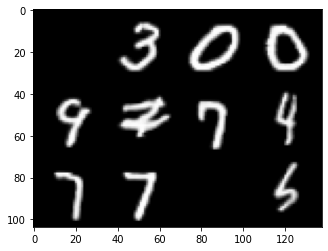

In [ ]:
ignore_loss = 1 # include_all = 0, ignore_sx = 1, ignore_sz = 2, ignore_sx_and_sz = 3
if ignore_loss == 0:
    print('all losses included')
    pipline = run_experiments('./mnist/')
elif ignore_loss == 1:
    print('sx loss ignored')
    pipline = run_experiments('./mnist/', include_sx=False)
elif ignore_loss == 2:
    print('sz loss ignored')
    pipline = run_experiments('./mnist/', include_sz=False)
elif ignore_loss == 3:
    print('sx and sz losses ignored')
    pipline = run_experiments('./mnist/', include_sx=False, include_sz=False)
else:
    print('all losses included')
    pipline = run_experiments('./mnist/')

In [ ]:
model = pipline.model
model.eval()
# base_model = deepcopy(model)

BigBiGAN(
  (generator): GenBigGAN(
    (class_embedding): Embedding(10, 32)
    (linear): LinearSN(
      (layer): Linear(in_features=25, out_features=4096, bias=True)
    )
    (pre_up_blocks): Sequential(
      (0): UpResnetBlock(
        (skip_upsample): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
        (skip_conv): Conv2dSN(
          (layer): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (bn1): CondBatchNorm2d(
          (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
          (linear): Linear(in_features=57, out_features=512, bias=True)
        )
        (relu1): ReLU()
        (upsample): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
        (conv1): Conv2dSN(
          (layer): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (bn2): CondBatchNorm2d(
          (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_sta

# Set path (directory) to train and test files here (Note: files retrieved from torchvision)

In [ ]:
test_loader = get_loader('./mnist/', 32, 256, train=False)
img_generator(model, test_loader, './real_images/', './gen_images/')

In [ ]:
!zip -r /content/sx_gen.zip /content/gen_images
!zip -r /content/sx_real.zip /content/real_images

Streaming output truncated to the last 5000 lines.
  adding: content/real_images/real_4792.png (stored 0%)
  adding: content/real_images/real_2954.png (stored 0%)
  adding: content/real_images/real_5178.png (stored 0%)
  adding: content/real_images/real_1446.png (stored 0%)
  adding: content/real_images/real_5841.png (stored 0%)
  adding: content/real_images/real_6751.png (stored 0%)
  adding: content/real_images/real_3759.png (stored 0%)
  adding: content/real_images/real_1783.png (stored 0%)
  adding: content/real_images/real_6623.png (stored 0%)
  adding: content/real_images/real_8765.png (stored 0%)
  adding: content/real_images/real_5519.png (stored 0%)
  adding: content/real_images/real_7701.png (stored 0%)
  adding: content/real_images/real_2646.png (stored 0%)
  adding: content/real_images/real_9635.png (stored 0%)
  adding: content/real_images/real_5930.png (stored 0%)
  adding: content/real_images/real_6113.png (stored 0%)
  adding: content/real_images/real_5922.png (stored 0

In [ ]:
train_tester = cal_linearAcc(model)
print(train_tester.ts_metrics)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training: 0/3510 -- loss: 2.3405089378356934
Training: 1/3510 -- loss: 2.358009099960327
Training: 2/3510 -- loss: 2.3325939178466797
Training: 3/3510 -- loss: 2.311814546585083
Training: 4/3510 -- loss: 2.2845354080200195
Training: 5/3510 -- loss: 2.2607126235961914
Training: 6/3510 -- loss: 2.2425689697265625
Training: 7/3510 -- loss: 2.2022368907928467
Training: 8/3510 -- loss: 2.1847195625305176
Training: 9/3510 -- loss: 2.108476400375366
Training: 10/3510 -- loss: 2.0981152057647705
Training: 11/3510 -- loss: 2.1088497638702393
Training: 12/3510 -- loss: 2.121842861175537
Training: 13/3510 -- loss: 2.0129494667053223
Training: 14/3510 -- loss: 2.0773234367370605
Training: 15/3510 -- loss: 2.1017866134643555
Training: 16/3510 -- loss: 2.0432932376861572
Training: 17/3510 -- loss: 2.0011448860168457
Training: 18/3510 -- loss: 2.0990607738494873
Training: 19/3510 -- loss: 2.038274049758911
Training: 20/3510 -- loss: 2.0017669200897217
Training: 21/3510 -- loss: 2.0338268280029297
Tra

In [1]:
!pip install pytorch-fid

  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.0-cp37-none-any.whl size=10547 sha256=3a8a751ec0eea8aebb4fa50b8c49cb0e22c8676e01ee47f0cf024222fde1130e
  Stored in directory: /root/.cache/pip/wheels/72/36/3c/4f3fb256f62d24bef52636f66f21667bc21caa637ce92f0e53
Successfully built pytorch-fid


In [9]:
!python -m pytorch_fid -h

usage: __main__.py [-h] [--batch-size BATCH_SIZE] [--device DEVICE]
                   [--dims {64,192,768,2048}]
                   path path

positional arguments:
  path                  Paths to the generated images or to .npz statistic
                        files

optional arguments:
  -h, --help            show this help message and exit
  --batch-size BATCH_SIZE
                        Batch size to use (default: 50)
  --device DEVICE       Device to use. Like cuda, cuda:0 or cpu (default:
                        None)
  --dims {64,192,768,2048}
                        Dimensionality of Inception features to use. By
                        default, uses pool3 features (default: 2048)


## Set path to images zip files if they are not in a seperate directory. Otherwise, set the direstory path in the next cell

In [ ]:
!unzip sx_gen.zip -d ./sx_gen
!unzip sz_gen.zip -d ./sz_gen
!unzip sxsz_gen.zip -d ./sxsz_gen
!unzip all_gen.zip -d ./all_gen
!unzip all_real.zip -d ./all_real

In [18]:
!python -m pytorch_fid sxsz_gen/content/gen_images/ all_real/content/real_images/ --device cuda:0

100% 200/200 [00:23<00:00,  8.39it/s]
100% 200/200 [00:23<00:00,  8.38it/s]
FID:  39.491525862486384


# Set path to saved pickle results file

******************** Test Metrics: ********************
Accuracy: 0.270
Weighted Precision: 0.242
Weighted Recall: 0.270
Weighted F1-score: 0.243
*******************************************************


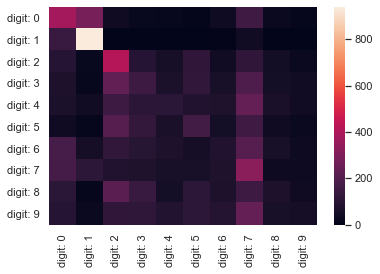

In [10]:
with open('./results/sxsz_results_test.pkl', 'rb') as results_file:
    test_results = pickle.load(results_file)
classes = [f'digit: {x}' for x in list(range(10))]
plt.figure()
test_confm = pd.DataFrame(test_results['confusion_matrix'], classes, classes)
sn.set(font_scale=1)
sn.heatmap(
    test_confm, 
    annot= False, 
    annot_kws = {"size": 10}
)
plt.autoscale(True)
plt.savefig(os.path.join('./results/', 'sxsz-test-confusion-matrix.png'), dpi=300, bbox_inches="tight")
print(f'{"*"*20} Test Metrics: {"*"*20}\n'
      f'Accuracy: {test_results["accuracy"]:.3f}\n'
      f'Weighted Precision: {test_results["precision"]:.3f}\n'
      f'Weighted Recall: {test_results["recall"]:.3f}\n'
      f'Weighted F1-score: {test_results["f1_score"]:.3f}\n'
      f'{"*"*55}')